**数据预处理**

In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# 读取数据
need_date_time_columns=1 #是否需要时间作为特征
columns_to_drop=[] #需要删除的列
df = pd.read_csv('data//train.csv', parse_dates=['DateTime'])
# 转换所有应为数值的列为 float（防止字符串类型报错）
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]
# 强制转换为 float，如果有无法解析的值，设置为 NaN
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

df=df.drop(columns=columns_to_drop)
# 添加日期列
df['Date'] = df['DateTime'].dt.date  # 只保留年月日部分

# 计算 sub_metering_remainder（每分钟）
df['sub_metering_remainder'] = (df['Global_active_power'] * 1000 / 60) - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# 定义日级聚合函数
daily_agg = {
    'Global_active_power': lambda x: x.sum() / 60,
    'Global_reactive_power': lambda x: x.sum() / 60,
    'Sub_metering_1': 'sum',  # 已是 Wh，每分钟累计可以直接 sum
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'sub_metering_remainder': 'sum',

    'Voltage': 'mean',  # 电压波动，均值即可
    'Global_intensity': 'mean',  # 电流均值也合理

    'RR': 'first',  # 天气指标，一天一个值即可
    'NBJRR1': 'first',
    'NBJRR5': 'first',
    'NBJRR10': 'first',
    'NBJBROU': 'first'
}
for col in columns_to_drop:
    daily_agg.pop(col, None)

# 按日期聚合
df_daily = df.groupby('Date').agg(daily_agg).reset_index()
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
if need_date_time_columns:
    # 可以选择将日期列转回 datetime 类型
    df_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_daily['day_of_month'] = df_daily['Date'].dt.day
    df_daily['month'] = df_daily['Date'].dt.month
    df_daily['quarter'] = df_daily['Date'].dt.quarter
# 查看结果
print("预处理后日级数据：")
print(df_daily.info())
print(df_daily.head())
feature_cols = [col for col in df_daily.columns if col != 'Date']
scaler = MinMaxScaler()
df_daily_scaled = df_daily.copy()
df_daily_scaled[feature_cols] = scaler.fit_transform(df_daily[feature_cols])
print(df_daily_scaled.head())

预处理后日级数据：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    746 non-null    datetime64[ns]
 1   Global_active_power     746 non-null    float64       
 2   Global_reactive_power   746 non-null    float64       
 3   Sub_metering_1          746 non-null    float64       
 4   Sub_metering_2          746 non-null    float64       
 5   Sub_metering_3          746 non-null    float64       
 6   sub_metering_remainder  746 non-null    float64       
 7   Voltage                 746 non-null    float64       
 8   Global_intensity        746 non-null    float64       
 9   RR                      746 non-null    float64       
 10  NBJRR1                  746 non-null    float64       
 11  NBJRR5                  746 non-null    float64       
 12  NBJRR10                 746 non-null    

In [91]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# target_col = 'Global_active_power'
# # 计算皮尔逊相关系数矩阵
# corr_matrix = df_daily[feature_cols + [target_col]].corr()
#
# # 可视化热力图
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
# plt.title("Pearson Correlation Matrix")
# plt.tight_layout()
# plt.show()

In [92]:
# from sklearn.feature_selection import mutual_info_regression
#
# X = df_daily[feature_cols]
# y = df_daily[target_col]
#
# mi_scores = mutual_info_regression(X, y, random_state=0)
# mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
#
# # 可视化
# plt.figure(figsize=(10, 5))
# mi_series.plot(kind='bar', color='darkorange')
# plt.title(f'Mutual Information with Target: {target_col}')
# plt.ylabel('MI Score')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


构造监督学习数据集+Transformer模型设计+训练函数

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_supervised_data(df, input_window=90, output_window=90, target_col='Global_active_power'):
    """
    构造用于多变量时间序列预测的监督学习样本
    参数：
        df: 已按天聚合的 DataFrame，包含时间序列特征
        input_window: 输入时间步长（例如 90）
        output_window: 预测步长（例如 90 或 365）
        target_col: 预测目标列
    返回：
        X: shape = [样本数, input_window, 特征数]
        y: shape = [样本数, output_window]
    """
    data = df.copy()
    feature_cols = [col for col in data.columns if col != 'Date']

    X_list = []
    y_list = []

    for i in range(len(data) - input_window - output_window + 1):
        x_window = data[feature_cols].iloc[i : i + input_window].values
        y_window = data[target_col].iloc[i + input_window : i + input_window + output_window].values

        if not (np.isnan(x_window).any() or np.isnan(y_window).any()):
            X_list.append(x_window)
            y_list.append(y_window)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
import numpy as np

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(sequence_len, embed_dim)

    def get_positional_encoding(self, sequence_len, embed_dim):
        position = np.arange(sequence_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, embed_dim, 2) * -(np.log(10000.0) / embed_dim))
        pos_encoding = np.zeros((sequence_len, embed_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        return tf.constant(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :]

def build_transformer_model(input_len, feature_dim, output_len,
                             embed_dim=64, num_heads=4, ff_dim=128,
                             num_layers=2, dropout=0.1):
    inputs = Input(shape=(input_len, feature_dim))
    x = Dense(embed_dim)(inputs)
    x = PositionalEncoding(input_len, embed_dim)(x)

    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x, training=True)

    # 输出为逐点预测序列
    outputs = Dense(1)(x)  # (batch_size, input_len, 1)
    outputs = tf.keras.layers.Reshape((input_len,))(outputs)

    # 若 input_len 与 output_len 不等，则用 Dense 重新投影
    if input_len != output_len:
        outputs = Dense(output_len)(outputs)  # (batch_size, output_len)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def train_transformer_model(X_train, y_train, X_val, y_val,
                     input_timesteps, num_features, output_timesteps,
                     epochs=50, batch_size=64, n_runs=5):
    from tensorflow.keras import backend as K
    all_loss_per_run = []

    mse_list = []
    mae_list = []
    best_model = None
    best_mse = float('inf')

    for run in range(n_runs):
        print(f"\n===== Run {run+1}/{n_runs} =====")
        model = build_transformer_model(input_timesteps, num_features, output_timesteps)

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        history=model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),  # 显式验证集
            callbacks=[early_stopping],
            verbose=2
        )
        loss_list = history.history['loss']
        all_loss_per_run.append(loss_list)
        # 验证集评估（用于模型选择）
        loss, mae = model.evaluate(X_val, y_val, verbose=0)
        mse = loss

        print(f"Run {run+1} - MSE: {mse:.6f}, MAE: {mae:.6f}")

        mse_list.append(mse)
        mae_list.append(mae)

        if mse < best_mse:
            best_mse = mse
            best_model = model

        K.clear_session()

    results = {
        'mse_mean': np.mean(mse_list),
        'mse_std': np.std(mse_list),
        'mae_mean': np.mean(mae_list),
        'mae_std': np.std(mae_list),
    }

    print("\n===== Summary =====")
    print(f"MSE mean: {results['mse_mean']:.6f}, std: {results['mse_std']:.6f}")
    print(f"MAE mean: {results['mae_mean']:.6f}, std: {results['mae_std']:.6f}")

    return best_model,all_loss_per_run

#绘制loss收敛曲线


def plot_avg_training_loss(all_loss_per_run):
    # 对齐不同 run 的 epoch 长度（考虑 early stopping）
    min_epochs = min(len(losses) for losses in all_loss_per_run)

    # 截断并转置为 (min_epochs, n_runs)
    truncated_losses = np.array([losses[:min_epochs] for losses in all_loss_per_run])

    # 平均
    avg_loss = np.mean(truncated_losses, axis=0)

    # 画图
    plt.figure(figsize=(8, 5))
    plt.plot(avg_loss, label='Average Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Average Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

开始训练

In [94]:
epochs=100
n_runs=10
batch_size=8
input_window = 90
output_window = 365
target_col = 'Global_active_power'

X_full, y_full = create_supervised_data(df_daily_scaled, input_window, output_window, target_col)
print(f"X shape: {X_full.shape}, y shape: {y_full.shape}")
print(f"原始日级数据总天数: {df_daily.shape[0]}")
print(f"用于建模的样本数: {len(X_full)}")

# 划分训练集和验证集
train_ratio = 0.9
split_idx = int(len(X_full) * train_ratio)
X_train, X_val = X_full[:split_idx], X_full[split_idx:]
y_train, y_val = y_full[:split_idx], y_full[split_idx:]

print(f"训练集样本数: {len(X_train)}, 验证集样本数: {len(X_val)}")

num_features = X_train.shape[2]

model, history = train_transformer_model(
    X_train, y_train, X_val, y_val,
    input_window, num_features, output_window,
    epochs=epochs, batch_size=batch_size, n_runs=n_runs
)
# model.summary()


X shape: (292, 90, 17), y shape: (292, 365)
原始日级数据总天数: 746
用于建模的样本数: 292
训练集样本数: 262, 验证集样本数: 30

===== Run 1/10 =====
Epoch 1/100
33/33 - 7s - 216ms/step - loss: 0.2314 - mae: 0.3441 - val_loss: 0.0298 - val_mae: 0.1352
Epoch 2/100
33/33 - 1s - 26ms/step - loss: 0.0312 - mae: 0.1401 - val_loss: 0.0242 - val_mae: 0.1230
Epoch 3/100
33/33 - 1s - 25ms/step - loss: 0.0229 - mae: 0.1203 - val_loss: 0.0230 - val_mae: 0.1210
Epoch 4/100
33/33 - 1s - 24ms/step - loss: 0.0194 - mae: 0.1105 - val_loss: 0.0228 - val_mae: 0.1186
Epoch 5/100
33/33 - 1s - 24ms/step - loss: 0.0179 - mae: 0.1062 - val_loss: 0.0246 - val_mae: 0.1239
Epoch 6/100
33/33 - 1s - 24ms/step - loss: 0.0170 - mae: 0.1035 - val_loss: 0.0231 - val_mae: 0.1205
Epoch 7/100
33/33 - 1s - 24ms/step - loss: 0.0166 - mae: 0.1019 - val_loss: 0.0209 - val_mae: 0.1138
Epoch 8/100
33/33 - 1s - 24ms/step - loss: 0.0161 - mae: 0.1006 - val_loss: 0.0220 - val_mae: 0.1168
Epoch 9/100
33/33 - 1s - 26ms/step - loss: 0.0158 - mae: 0.0995 - val_lo

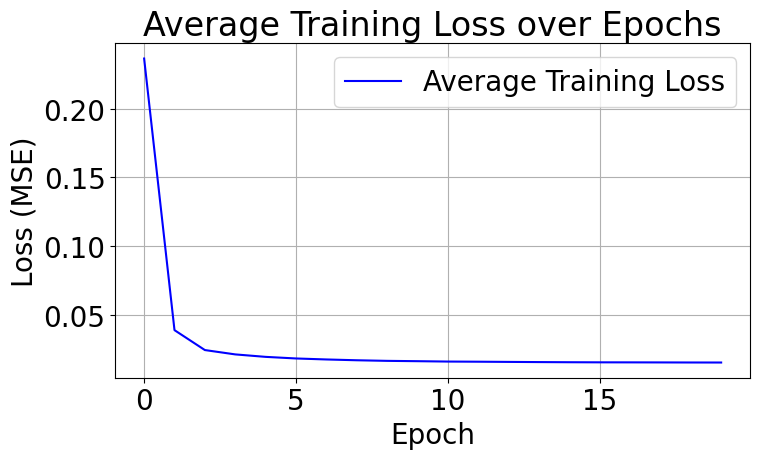

In [95]:
from matplotlib import pyplot as plt
plot_avg_training_loss(history)

测试集+作图

C:\Users\16693\AppData\Local\Temp\ipykernel_20080\1498520056.py:2: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('data/test.csv', header=None)


清洗后测试集天数: 684
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
测试集天数(原始日数据): 684
测试集每日特征缺失情况:
 Date                      0
Global_active_power       0
Global_reactive_power     0
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
sub_metering_remainder    0
Voltage                   0
Global_intensity          0
RR                        0
NBJRR1                    0
NBJRR5                    0
NBJRR10                   0
NBJBROU                   0
day_of_week               0
day_of_month              0
month                     0
quarter                   0
dtype: int64
预测窗口数(样本数): 230
预测窗口中有缺失值样本丢弃数: 0


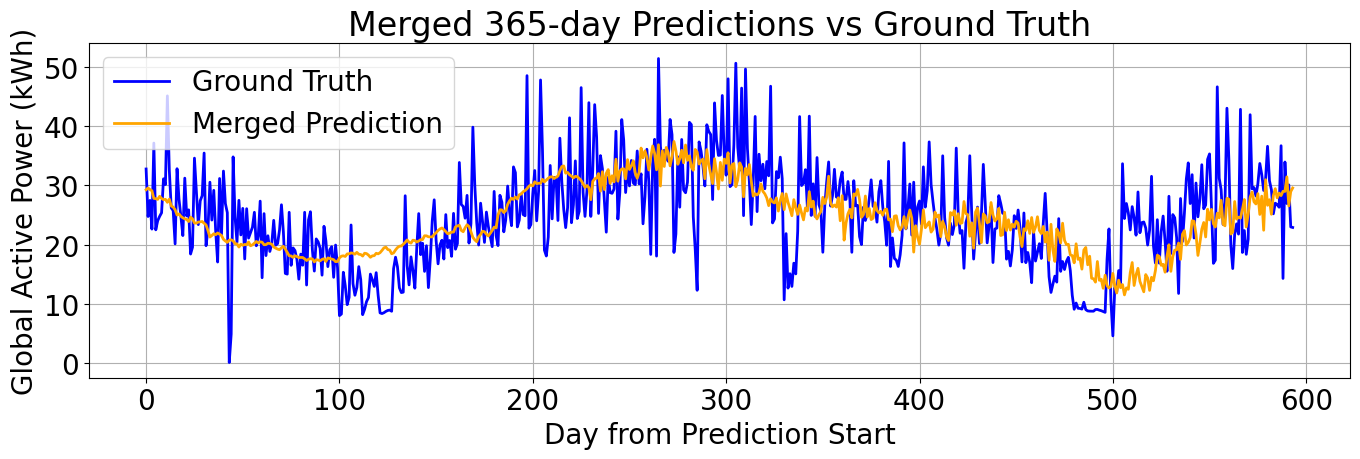

测试集评估指标:
MSE : 45.606673
RMSE: 6.753271
MAE : 5.273321
预测误差标准差: 6.746460


In [96]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
df_test = pd.read_csv('data/test.csv', header=None)

# Step 2：赋完整列名（按顺序）
df_test.columns = ["DateTime"]+numeric_cols


# 数值列转换（如有非数字或缺失，转为NaN）
df_test[numeric_cols] = df_test[numeric_cols].apply(pd.to_numeric, errors='coerce')
# 显式删除不需要字段
df_test = df_test.drop(columns=columns_to_drop)
df_test['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df_test['Date'] = df_test['DateTime'].dt.date

# 计算 sub_metering_remainder
df_test['sub_metering_remainder'] = (df_test['Global_active_power'] * 1000 / 60) - (
    df_test['Sub_metering_1'] + df_test['Sub_metering_2'] + df_test['Sub_metering_3'])

# 按天聚合
df_test_daily = df_test.groupby('Date').agg(daily_agg).reset_index()
if need_date_time_columns:
    df_test_daily['Date'] = pd.to_datetime(df_test_daily['Date'])
    df_test_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_test_daily['day_of_month'] = df_daily['Date'].dt.day
    df_test_daily['month'] = df_daily['Date'].dt.month
    df_test_daily['quarter'] = df_daily['Date'].dt.quarter
# ========== 关键修改点：丢弃含NaN的天 ==========
df_test_daily_clean = df_test_daily.dropna()
print(f"清洗后测试集天数: {len(df_test_daily_clean)}")

# 归一化（只对干净数据做）
df_test_daily_scaled = df_test_daily_clean.copy()
df_test_daily_scaled[feature_cols] = scaler.transform(df_test_daily_scaled[feature_cols])


def inverse_transform_target(scaler, feature_cols, data_1d, target_col='Global_active_power'):
    """
    把一维的目标列数据逆归一化。
    scaler: 训练时fit的Scaler
    feature_cols: 归一化时所有特征的列名列表
    data_1d: 目标列的一维归一化数据（如full_pred或full_true）
    返回：逆归一化后目标列一维数据
    """
    n = len(data_1d)
    temp = np.zeros((n, len(feature_cols)))
    # 找到目标列索引
    target_idx = feature_cols.index(target_col)
    temp[:, target_idx] = data_1d
    # 逆归一化
    inv_data = scaler.inverse_transform(temp)
    return inv_data[:, target_idx]


X_test_final, y_test_final = create_supervised_data(
    df_test_daily_scaled,
    input_window=input_window,
    output_window=output_window,
    target_col=target_col  # 一般是 'Global_active_power'
)
y_pred_final = model.predict(X_test_final)
print("测试集天数(原始日数据):", len(df_test_daily_scaled))
print("测试集每日特征缺失情况:\n", df_test_daily_scaled.isna().sum())
print("预测窗口数(样本数):", len(y_pred_final))
print("预测窗口中有缺失值样本丢弃数:", (len(df_test_daily_scaled) - input_window - output_window + 1) - len(y_pred_final))


# 初始化容器
total_days = input_window + (len(y_pred_final) - 1) + output_window
pred_sum = np.zeros(total_days)
true_sum = np.zeros(total_days)

# 替代平均融合：取最后一次预测
for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
    start_idx = input_window + i
    end_idx = start_idx + output_window

    pred_sum[start_idx:end_idx] = pred  # 直接覆盖
    true_sum[start_idx:end_idx] = true
# for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
#     start_idx = input_window + i
#     end_idx = start_idx + output_window
#
#     for j in range(output_window):
#         idx = start_idx + j
#         if pred_count[idx] == 0:
#             pred_sum[idx] = pred[j]
#             true_sum[idx] = true[j]
#             pred_count[idx] = 1
#             true_count[idx] = 1
# 取预测部分
full_pred = pred_sum[input_window:]
full_true = true_sum[input_window:]

# 反归一化
full_pred_inv = inverse_transform_target(scaler, feature_cols, full_pred, target_col)
full_true_inv = inverse_transform_target(scaler, feature_cols, full_true, target_col)

# 时间轴
days = np.arange(len(full_pred))
plt.rcParams.update({
    'font.size': 20,           # 全局基础字体大小
    'axes.titlesize': 24,      # 标题字体大小
    'axes.labelsize': 20,      # 坐标轴标签大小
    'xtick.labelsize': 20,     # X轴刻度标签大小
    'ytick.labelsize': 20,     # Y轴刻度标签大小
    'legend.fontsize': 20      # 图例字体大小
})
plt.figure(figsize=(14, 5))
plt.plot(days, full_true_inv, label='Ground Truth', color='blue', linewidth=2)
plt.plot(days, full_pred_inv, label='Merged Prediction', color='orange', linewidth=2)
plt.xlabel('Day from Prediction Start')
plt.ylabel('Global Active Power (kWh)')  # 单位改成实际单位
plt.title('Merged 365-day Predictions vs Ground Truth')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
true_values_to_show = full_true_inv
pred_values_to_show = full_pred_inv

mse = mean_squared_error(true_values_to_show, pred_values_to_show)

# RMSE
rmse = mse ** 0.5

# MAE
mae = mean_absolute_error(true_values_to_show, pred_values_to_show)
errors = pred_values_to_show- true_values_to_show
std_dev = np.std(errors)

print(f"测试集评估指标:")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"预测误差标准差: {std_dev:.6f}")

In [97]:
import json
list_data = full_pred_inv.tolist()
with open('tf-365.json', 'w', encoding='utf-8') as f:
    json.dump(list_data, f, ensure_ascii=False, indent=2)